<a href="https://colab.research.google.com/github/Medalcode/Colab1/blob/main/Clasificacion%20Malware%20IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   e_cblp  e_cp  e_cparhdr  e_maxalloc  e_sp  e_lfanew  NumberOfSections  \
0     144     3          4       65535   184       256                 4   
1     144     3          4       65535   184       184                 4   
2     144     3          4       65535   184       272                 5   
3     144     3          4       65535   184       184                 1   
4     144     3          4       65535   184       224                 5   

   CreationYear  FH_char0  FH_char1  ...  sus_sections  non_sus_sections  \
0             1         0         1  ...             1                 3   
1             1         0         1  ...             1                 3   
2             1         0         1  ...             1                 4   
3             1         0         1  ...             0                 1   
4             1         0         1  ...             1                 4   

   packer  packer_type    E_text    E_data  filesize    E_file  fileinfo  \
0       0 

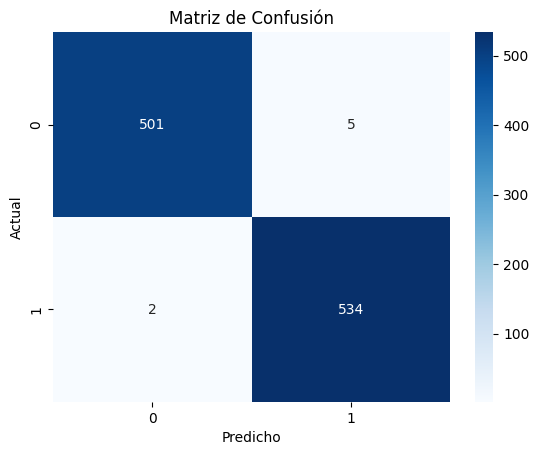


Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       506
           1       0.99      1.00      0.99       536

    accuracy                           0.99      1042
   macro avg       0.99      0.99      0.99      1042
weighted avg       0.99      0.99      0.99      1042



['mi_modelo.joblib']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Cargar el dataset (asegúrate de tener configurada tu API key de Kaggle)
# !kaggle datasets download -d saurabhshahane/classification-of-malwares

# Cargar el dataset
data = pd.read_csv("datos_malware.csv")

# Exploración inicial (adapta según tus necesidades)
print(data.head())
print(data.info())
print(data.describe())

# Preprocesamiento
# Identificar las columnas numéricas y categóricas
numeric_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Rellenar los valores faltantes en las columnas numéricas con la media
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Convertir las columnas categóricas a numéricas (one-hot encoding)
# Exclude 'class' column from one-hot encoding if it's categorical
if 'class' in categorical_cols:
    categorical_cols = categorical_cols.drop('class') # Exclude 'class'
data = pd.get_dummies(data, columns=categorical_cols)

# Separa las características y la variable objetivo
# Check if 'class' column exists (likely the target column)
if 'class' in data.columns:
    X = data.drop('class', axis=1)
    y = data['class']
else:
    raise KeyError("Target column ('class') not found. Please check your data.")

# Store the original column names before scaling
original_X_columns = X.columns

# Escalado de características (opcional, puede mejorar el rendimiento)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a smaller subset for hyperparameter tuning (optional)
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=42  # Use 80% for the held-out set
)

# Definición del modelo y búsqueda de hiperparámetros (opcional)
param_grid = param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3) # Reduced from cv=5
grid_search.fit(X_train_subset, y_train_subset) # Use the subset for GridSearchCV
best_params = grid_search.best_params_

# Entrenamiento del modelo con los mejores hiperparámetros
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, y_train)

# Hacer predicciones
predicciones = rf.predict(X_test)

# Crear un DataFrame para almacenar los resultados
resultados = pd.DataFrame({'Actual': y_test, 'Predicho': predicciones})

# Calcular métricas de clasificación
resultados['Verdadero Positivo'] = np.where((resultados['Actual']==1) & (resultados['Predicho']==1), 1, 0)
resultados['Falso Positivo'] = np.where((resultados['Actual']==0) & (resultados['Predicho']==1), 1, 0)
resultados['Falso Negativo'] = np.where((resultados['Actual']==1) & (resultados['Predicho']==0), 1, 0)
resultados['Verdadero Negativo'] = np.where((resultados['Actual']==0) & (resultados['Predicho']==0), 1, 0)

# Calcular métricas agregadas
TP = resultados['Verdadero Positivo'].sum()
FP = resultados['Falso Positivo'].sum()
FN = resultados['Falso Negativo'].sum()
TN = resultados['Verdadero Negativo'].sum()

# Mostrar la matriz de confusión en un gráfico de calor
sns.heatmap(confusion_matrix(y_test, predicciones), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación más detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, predicciones))

# Guardar el modelo entrenado
joblib.dump(rf, 'mi_modelo.joblib') # Call the function using joblib.dump()

In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler


def clasificar_nuevos_datos(nuevo_archivo, original_X_columns, num_resultados=None):
    """Clasifica nuevos datos utilizando el modelo entrenado.

    Args:
        nuevo_archivo: Nombre del archivo CSV con los nuevos datos.
        original_X_columns: List of column names from the original training data.
        num_resultados: Número de resultados a mostrar (opcional).
                        Si es None, se muestran todos.

    Returns:
        Un DataFrame con las predicciones.
    """

    # Cargar el modelo pre-entrenado
    rf = joblib.load('mi_modelo.joblib')

    # Cargar los nuevos datos
    nuevos_datos = pd.read_csv(nuevo_archivo)

    # Preprocesamiento (utilizando las columnas numéricas y categóricas originales)
    numeric_cols = original_X_columns[original_X_columns.isin(nuevos_datos.select_dtypes(include=['number']).columns)]
    categorical_cols = original_X_columns[original_X_columns.isin(nuevos_datos.select_dtypes(include=['object']).columns)]

    # Rellenar los valores faltantes en las columnas numéricas con la media
    for col in numeric_cols:
        if col in nuevos_datos.columns:
            nuevos_datos[col] = nuevos_datos[col].fillna(nuevos_datos[col].mean())

    # Codificación one-hot de las columnas categóricas
    nuevos_datos = pd.get_dummies(nuevos_datos, columns=categorical_cols)

    # asegurarse que los datos nuevos tengan las mismas columnas que los datos de entrenamiento
    nuevos_datos = nuevos_datos.reindex(columns=original_X_columns, fill_value=0)

    # Escalado de características
    scaler = StandardScaler()
    global data  # Accede a los datos de entrenamiento originales
    scaler.fit(data[original_X_columns])
    nuevos_datos_scaled = scaler.transform(nuevos_datos[original_X_columns])

    # Hacer predicciones
    predicciones = rf.predict(nuevos_datos_scaled)

    # Crear un DataFrame con los resultados
    resultados_nuevos = pd.DataFrame({'ID': nuevos_datos.index,
                                      'Predicción': predicciones,
                                      'Clasificación': ['Benigno' if pred == 0 else 'Malware' for pred in predicciones]})

    # Controlar el número de resultados a mostrar
    if num_resultados is not None:
        return resultados_nuevos.head(num_resultados)
    else:
        return resultados_nuevos


def cargar_datos(ruta_archivo, num_filas):
    """Loads data from a CSV file, returning only the first 'num_filas' rows."""
    try:
        data = pd.read_csv(ruta_archivo, nrows=num_filas)
        return data
    except FileNotFoundError:
        print(f"Error: File '{ruta_archivo}' not found.")
        return None

if datos is not None:
    # Clasificación de los datos
    num_resultados_a_mostrar = 6  # Mostrará X lineas del resultado
    nuevos_resultados = clasificar_nuevos_datos(ruta_archivo, original_X_columns, num_resultados_a_mostrar)

    # Mostrar los resultados
    print(nuevos_resultados)


   ID  Predicción Clasificación
0   0           0       Benigno
1   1           1       Malware
2   2           1       Malware
3   3           0       Benigno
4   4           0       Benigno
5   5           1       Malware
